In [21]:
import jax
import gymnax
import pandas as pd
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

In [4]:
%config InlineBackend.figure_format = "retina"

In [5]:
%load_ext autoreload
%autoreload 2

## Could you learn?

In [6]:
class CNN(nn.Module):
    num_actions: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.relu(x)
        x = nn.Dense(features=84)(x)
        x = nn.relu(x)
        # x = nn.Dense(20)(x)
        # x = nn.relu(x)
        x = nn.Dense(self.num_actions, name="last_layer")(x)
        # x = x - jax.nn.logsumexp(x)
        return x.squeeze()

model = CNN(num_actions=10)

In [7]:
from rebayes_mini.methods import low_rank_last_layer as onflow
from rebayes_mini.callbacks import get_null

## Setup environment

In [8]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    mean = jax.nn.softmax(eta)
    return mean

def cov_fn(eta, eps=0.1):
    mean = jax.nn.softmax(eta)
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [9]:
key = jax.random.PRNGKey(3141)

In [14]:
key_env, key_env_step, key_act, key_init_params, key_run = jax.random.split(key, 5)

## Initialise

In [216]:
# Instantiate the environment & its settings.
env, env_params = gymnax.make("MNISTBandit-bsuite")

In [16]:
agent = onflow.LowRankLastLayer(
    mean_fn,
    cov_fn,
    rank=50,
    dynamics_hidden=0.0,
    dynamics_last=0.0
)

In [17]:
# Reset the environment.
context, state = env.reset(key_env, env_params)

# Initialise agent
params_init = model.init(key_init_params, context[..., None])
bel_init = agent.init_bel(params_init, low_rank_diag=True, cov_hidden=0.0)

# Sample a random action.
action = env.action_space(env_params).sample(key_act)

context_init, state_init, reward, done, _ = env.step(key_env_step, state, action, env_params)

/home/gerardoduran/miniconda3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [18]:
def step(state, t):
    key_step = jax.random.fold_in(key_run, t)
    key_step, key_take = jax.random.split(key_step)
    
    bel, context, env_state = state
    
    # Take action
    action = agent.sample_predictive(key_take, bel, context[..., None]).argmax()

    # Obtain reward
    is_not_correct = -1 * (action != env_state.correct_label)
    y = jax.nn.one_hot(env_state.correct_label * is_not_correct, 10)

    # Update belief

    bel_update = agent.update(bel, y, context[..., None])

    
    # Take next step
    context_new, env_state, reward, done, _ = env.step(key_step, env_state, action, env_params)
    

    return (bel_update, context_new, env_state), (y, reward)

In [19]:
%%time
u_init = (bel_init, context_init, state_init)
steps = 2_000

state_final, (actions, rewards) = jax.lax.scan(step, u_init, jnp.arange(steps))
rewards = jax.block_until_ready(rewards)
rewards = (rewards + 1) / 2

CPU times: user 17 s, sys: 262 ms, total: 17.3 s
Wall time: 6.83 s


<Axes: >

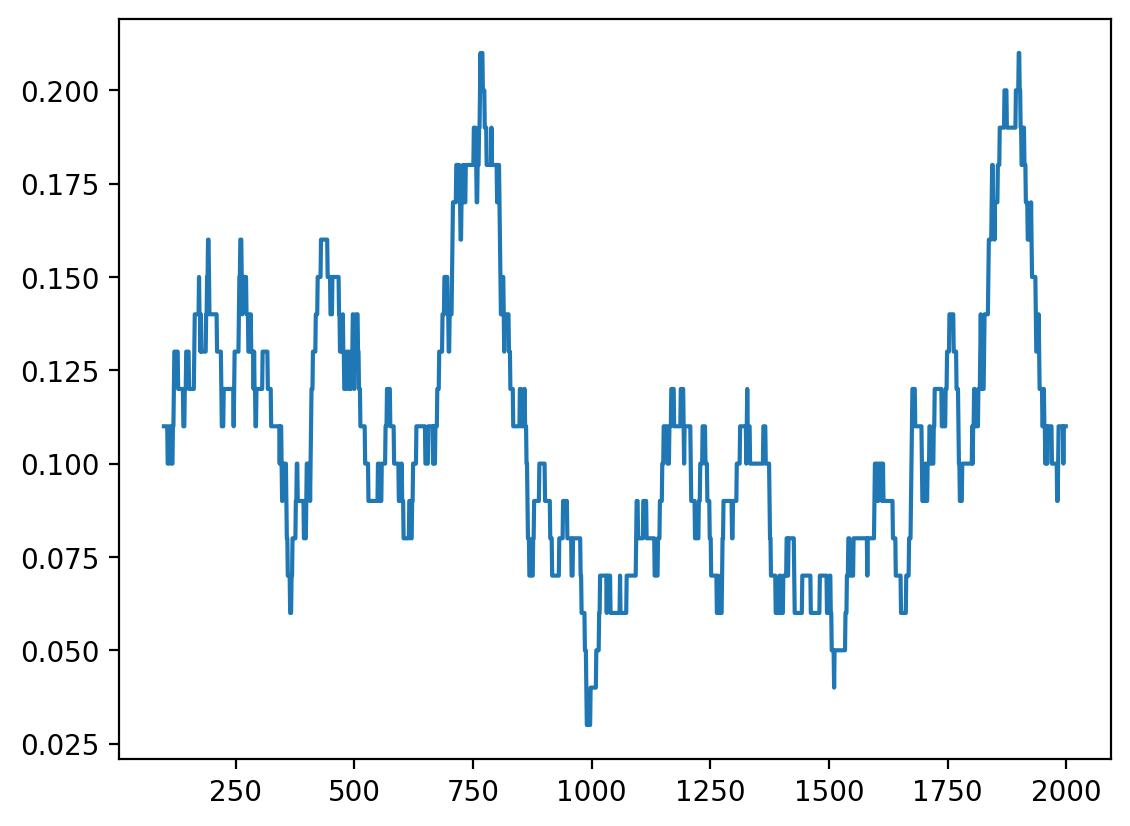

In [22]:
pd.Series(rewards).rolling(100).mean().plot()

## Online learning: full information setting

In [217]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    mean = jax.nn.softmax(eta)
    return mean


def cov_fn(eta, eps=0.1):
    mean = jax.nn.softmax(eta)
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [218]:
def step(state, t):
    key_step = jax.random.fold_in(key_run, t)
    key_step, key_take = jax.random.split(key_step)
    
    bel, context, env_state = state
    
    # Obtain reward
    y = jax.nn.one_hot(env_state.correct_label, 10)

    # Update belief
    action = agent.mean_fn(bel.mean_hidden, bel.mean_last, context[..., None]).argmax()
    bel_update = agent.update(bel, y, context[..., None])

    
    # Take next step
    context_new, env_state, reward, done, _ = env.step(key_step, env_state, action, env_params)

    return (bel_update, context_new, env_state), (y, reward)

In [219]:
agent = onflow.LowRankLastLayer(
    mean_fn,
    cov_fn,
    rank=50,
    dynamics_hidden=0.0,
    dynamics_last=1e-4
)

In [220]:
%%time
bel_init = agent.init_bel(params_init, low_rank_diag=True, cov_hidden=1.0, cov_last=1.0)
u_init = (bel_init, context_init, state_init)
steps = 2_000

state_final, (actions, rewards) = jax.lax.scan(step, u_init, jnp.arange(steps))
rewards = jax.block_until_ready(rewards)
rewards = (rewards + 1) / 2

CPU times: user 19.9 s, sys: 389 ms, total: 20.3 s
Wall time: 7.41 s


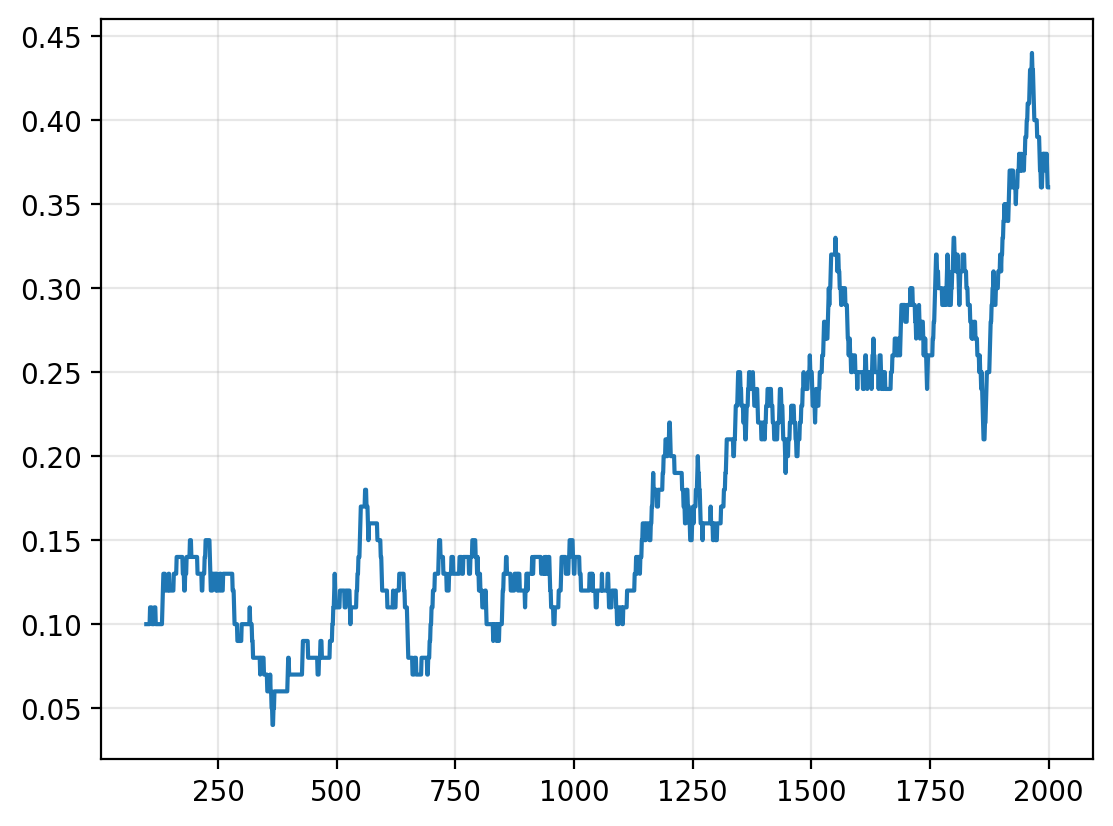

In [221]:
pd.Series(rewards).rolling(100).mean().plot()
plt.grid(alpha=0.3)

## Neural bandits: partial information setting ($\epsilon$-greedy)

In [343]:
def mean_fn(params, x):
    if isinstance(x, tuple):
        action = x[0]
        x = x[1]
        eta = model.apply(params, x)
        mean = jax.nn.sigmoid(eta[action])
        return jnp.atleast_1d(mean)
    else:
        eta = model.apply(params, x)
        return eta


def cov_fn(x, eps=0.1):
    return jnp.eye(1) * (x * (1 - x) + 0.01)
    mean = jax.nn.softmax(eta)
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [362]:
eps = 0.01
def step(state, t):
    key_step = jax.random.fold_in(key_run, t)
    key_step, key_take = jax.random.split(key_step)
    
    bel, context, env_state = state
    
    # Take action
    key_eps, key_take = jax.random.split(key_take)
    yhat = agent.mean_fn(bel.mean_hidden, bel.mean_last, context[..., None])
    action = yhat.argmax()
    take_random = jax.random.bernoulli(key_eps, p=eps)
    action_random = jax.random.choice(key_take, 10)

    action = action * (1 - take_random) + action_random * take_random
    action = action.astype(int)
    
    # Obtain reward
    y = jax.nn.one_hot(env_state.correct_label, 10)[action]

    # Update belief
    X = (action, context[..., None])
    bel_update = agent.update(bel, y, X)

    
    # Take next step
    context_new, env_state, reward, done, _ = env.step(key_step, env_state, action, env_params)

    return (bel_update, context_new, env_state), (action, reward)

In [363]:
%%time
agent = onflow.LowRankLastLayer(
    mean_fn,
    cov_fn,
    rank=50,
    dynamics_hidden=1e-6,
    dynamics_last=1e-6
)


bel_init = agent.init_bel(params_init, low_rank_diag=True, cov_hidden=1.0, cov_last=1.0)
u_init = (bel_init, context_init, state_init)
steps = 5_000

state_final, (actions, rewards) = jax.lax.scan(step, u_init, jnp.arange(steps))
rewards = jax.block_until_ready((rewards + 1) / 2)

CPU times: user 14.3 s, sys: 563 ms, total: 14.9 s
Wall time: 11 s


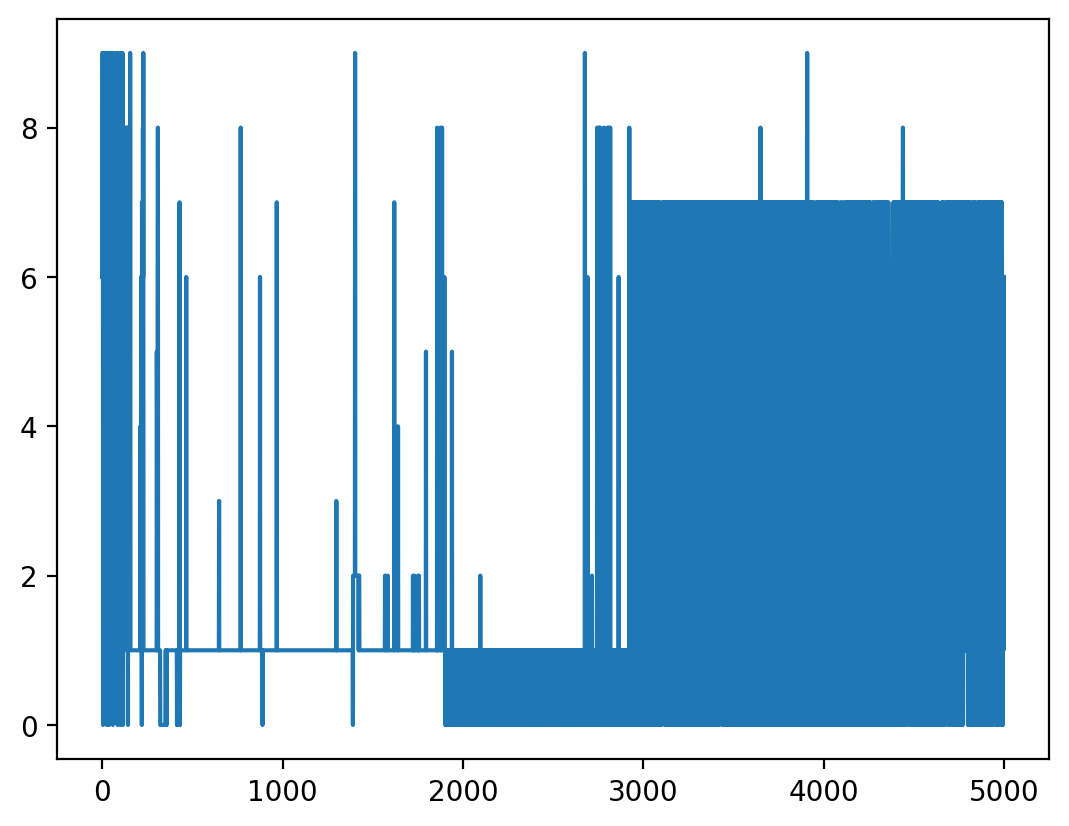

In [364]:
plt.plot(actions)

In [365]:
bel_init.mean_last[:20]

Array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.2053171 ,  0.0182943 ,  0.06897432, -0.24667253, -0.11349624,
       -0.11691906, -0.05933663, -0.02370933,  0.09744877,  0.02827537],      dtype=float32)

In [366]:
state_final[0].mean_last[:20]

Array([-0.763108  , -1.2791582 , -1.0609487 , -0.94158673, -1.1111498 ,
       -1.1176491 , -1.4783506 , -0.620346  , -1.0078636 , -0.88418347,
       -0.46513325,  0.25353524, -0.07762562, -0.39139068, -0.23251222,
       -0.24558552, -0.45456448, -1.6207179 ,  0.05762066, -0.12051889],      dtype=float32)

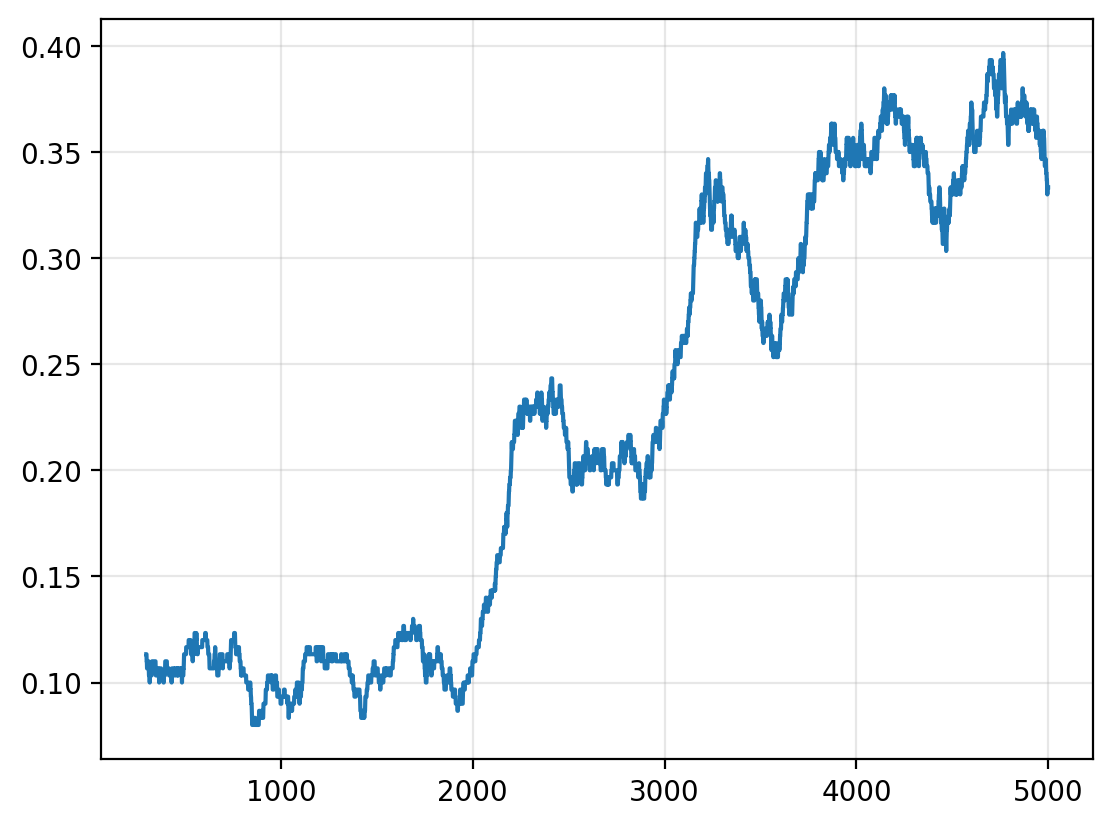

In [371]:
pd.Series(rewards).rolling(300).mean().plot()
plt.grid(alpha=0.3)

## Gym lunar lander

In [667]:
%config InlineBackend.figure_format = "retina"

In [111]:
import gym

In [195]:
import jax
import jax.numpy as jnp

In [646]:
import matplotlib.pyplot as plt

In [682]:
from rebayes_mini.methods import low_rank_filter_revised as lrkf
from rebayes_mini.methods import base_filter

In [683]:
env = gym.make("LunarLander-v2")

In [684]:
class LinearPolicy(nn.Module):
    n_actions: int
    n_features: int
    
    @nn.compact
    def __call__(self, x):
        a = x[..., 0]
        x = x[..., 1:]
        embedding = nn.Embed(self.n_actions, self.n_features)(a.astype(int))
        x = jnp.einsum("...j,...j->...", embedding, x)
        return x

In [685]:
key = jax.random.PRNGKey(314)
X_init = jnp.ones(env.observation_space.shape[0] + 1)
model = LinearPolicy(n_actions=env.action_space.n, n_features=env.observation_space.shape[0])
params_init = model.init(key, X_init[None, :])
jax.tree.map(jnp.shape, params_init)

{'params': {'Embed_0': {'embedding': (4, 8)}}}

In [757]:
agent = lrkf.LowRankCovarianceFilter(
    model.apply,
    lambda x: jnp.eye(1) * 1.0,
    dynamics_covariance=1e-4,
    rank=32
)


# agent = base_filter.ExtendedFilter(
#     model.apply,
#     lambda x: jnp.eye(1) * 1.0,
#     dynamics_covariance=0.0
# )

@jax.jit
def sample_predictives(key, bel, state):
    state = jnp.atleast_1d(state)
    actions = jnp.arange(4)
    keys = jax.random.split(key, 4)
    @jax.vmap
    def _sample(key, action):
        X = jnp.c_[action, state]
        sample = agent.sample_predictive(key, bel_init, X)
        return sample
    samples = _sample(keys, actions)
    return samples

In [758]:
from tqdm import tqdm

In [761]:
@jax.jit
def update(bel, y, X):
    return agent.update(bel, y, X[None, :])

In [764]:
gamma = 0.9999
state_prev, _ = env.reset(seed=314)
action_prev = 0
bel_init = agent.init_bel(params_init, cov=10.0)
bel = bel_init

steps = 8_000
episode_reward = 0.0
final_rewards = []
n_episodes = 0
ewm_episode = 0.0
rewards = np.zeros(steps)

for s in (pbar := tqdm(range(steps))):
    key_t = jax.random.fold_in(key, s)
    action_value_samples = sample_predictives(key_t, bel, state_prev[None, :])
    action = action_value_samples.argmax().item()
    state_next, reward, terminated, truncated, info = env.step(action)
    
    if terminated:
        _, key_new = jax.random.split(key_t)
        state_prev, info = env.reset()
        action_value_samples = sample_predictives(key_t, bel, state_prev[None, :])
        action = action_value_samples.argmax().item()
        final_rewards.append(episode_reward)
        ewm_episode = 0.3 * episode_reward + (1 - 0.3) * ewm_episode
        pbar.set_description(f"EWM @ {n_episodes}: {ewm_episode:0.2f}")
        episode_reward = 0.0
        n_episodes += 1
        continue
    else:
        rewards[s] = reward
        episode_reward += reward
    
    X_prev = jnp.insert(state_prev, 0, jnp.array([action_prev]))
    
    X_next = jnp.insert(state_next, 0, jnp.array([action]), 0)
    y = reward + gamma * agent.mean_fn(bel.mean, X_next)
    
    state_prev = state_next
    action_prev = action
    
    # bel = agent.update(bel, y, X_next[None, :])
    # bel = agent.update(bel, bel, y, X_prev[None, :])
    bel = update(bel, y, X_prev)

EWM @ 60: -111.05: 100%|█████████████████████████████████████████████████████████████████████████████████| 8000/8000 [02:33<00:00, 52.27it/s]


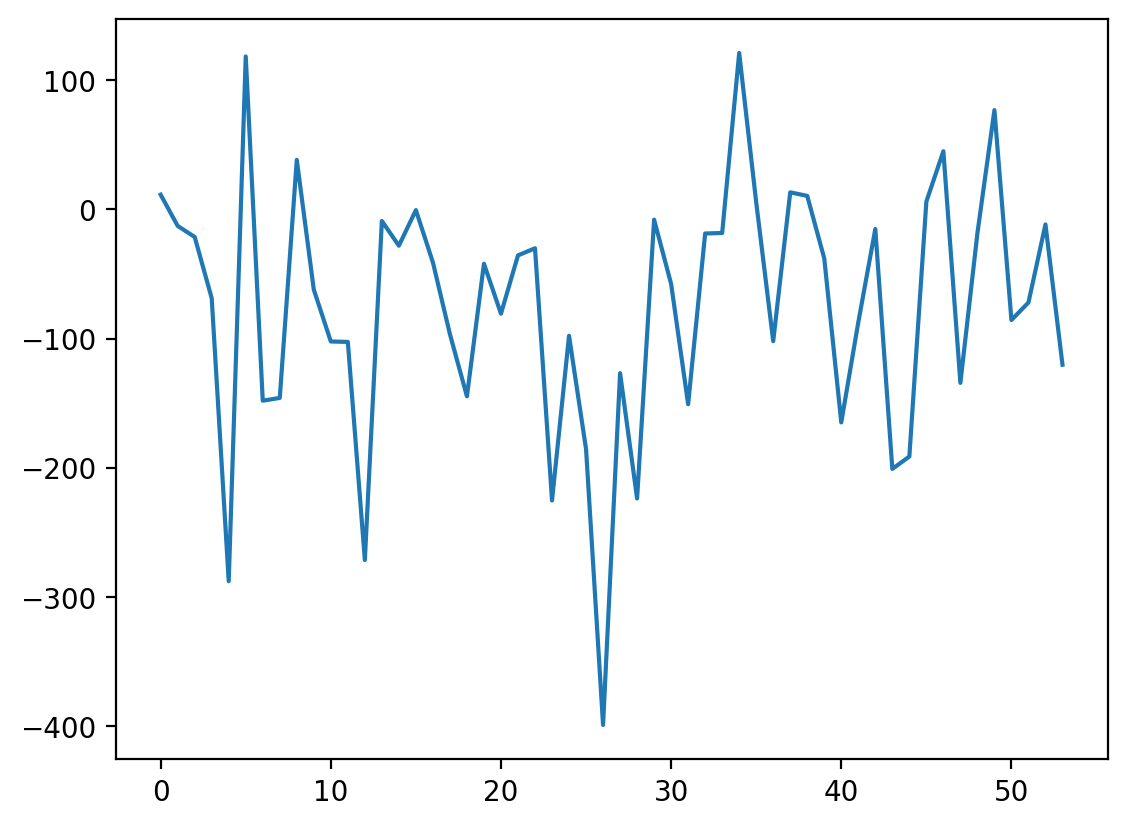

In [763]:
plt.plot(np.array(final_rewards))

In [618]:
action_value_samples = sample_predictives(key, bel, state_prev[None, :])
action = action_value_samples.argmax().item()

In [619]:
state_next, reward, terminated, truncated, info = env.step(action)

In [620]:
X_prev = jnp.insert(observation_next, 0, jnp.array([action_prev]))
yhat = agent.mean_fn(bel_init.mean, X_prev)

In [621]:
X_next = jnp.insert(observation_next, 0, jnp.array([action]), 0)
y = reward + gamma * agent.mean_fn(bel_init.mean, X_next)
state_prev = state_next

In [622]:
reward

np.float64(0.4749850519668257)